# Taxi Fare Prediction Modeling


### Introduction
The objective of this study is to develop a predictive model for taxi fares using the NYC yellow taxi trip dataset from 2023. The goal is to identify key factors influencing fare amounts and leverage machine learning techniques to create a model that accurately estimates fares. This model aims to provide a structured fare system for Tbilisi, Georgia.

### Summary of EDA Insights and Hypotheses
Key insights from the exploratory data analysis include:
- Fare amount, trip distance, trip duration, speed, and tip amount distributions are highly right-skewed, necessitating transformations.
- Fare amount has strong positive correlations with trip distance and trip duration.
- Time of day, day type, season, and holidays significantly impact fare amounts.
- Proper handling of outliers is crucial for accurate model predictions.

Hypotheses:
1. Longer trip distances and durations result in higher fares.
2. Fares vary by time of day, day of the week, and season, with peaks during special events and holidays.
3. Higher average speeds may correlate with higher fares due to longer distances covered in shorter times.
4. Higher fares tend to receive higher tips.



In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
# KNN with reduced dimensions
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df



In [3]:
from scipy import stats

def remove_outliers_zscore(df, columns, threshold=1):
    for col in columns:
        df = df[(np.abs(stats.zscore(df[col])) < threshold)]
    return df




In [4]:
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted for {model_name}')
    plt.show()

In [5]:
def plot_residuals(y_test, residuals, model_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.title(f'Residuals Distribution for {model_name}')
    plt.show()

In [6]:
def remove_domain_outliers(df):
    df = df[df['fare_amount'].between(3, 200)]  # example ranges
    df = df[df['trip_distance'].between(0.5, 50)]
    df = df[df['trip_duration'].between(1, 120)]
    df = df[df['speed_mph'].between(1, 60)]
    df = df[df['tip_amount'].between(0, 50)]
    return df


In [7]:
# Load the dataset
df = pd.read_parquet('sampled_taxi_dataset_v.1.parquet')
df.head()

,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,distance_bins,pickup_time_of_day,pickup_season,passenger_count_category,pickup_day_type,transaction_month,trip_duration,trip_duration_hours,PUcategory,DOcategory,is_holiday,speed_mph
21588994,1,16.60,1,67.4,16.00,10-20 miles,afternoon,autumn,low,weekday,10,46.950000,0.782500,Airport,Suburbs,0,21.214058
23139565,1,15.80,1,61.1,5.00,10-20 miles,afternoon,autumn,low,weekend,10,40.133333,0.668889,Airport,Suburbs,0,23.621262
18758042,3,17.62,1,84.2,0.10,10-20 miles,afternoon,autumn,medium,weekday,9,77.683333,1.294722,Airport,Suburbs,0,13.609097
19435420,1,11.16,1,53.4,13.87,10-20 miles,afternoon,autumn,low,weekend,9,47.883333,0.798056,Airport,City Center,0,13.983989
19850690,2,8.17,1,41.5,10.45,5-10 miles,afternoon,autumn,medium,weekday,9,34.400000,0.573333,Airport,City Center,0,14.250000


In [8]:
# Features to retain
features_to_retain = [
    'trip_distance', 'trip_duration', 'speed_mph', 'tip_amount', 
    'pickup_time_of_day', 'pickup_day_type', 'pickup_season', 
    'is_holiday', 'PUcategory', 'DOcategory', 'fare_amount'
]

# Retain only the necessary features
df = df[features_to_retain]
df.head()


,trip_distance,trip_duration,speed_mph,tip_amount,pickup_time_of_day,pickup_day_type,pickup_season,is_holiday,PUcategory,DOcategory,fare_amount
21588994,16.60,46.950000,21.214058,16.00,afternoon,weekday,autumn,0,Airport,Suburbs,67.4
23139565,15.80,40.133333,23.621262,5.00,afternoon,weekend,autumn,0,Airport,Suburbs,61.1
18758042,17.62,77.683333,13.609097,0.10,afternoon,weekday,autumn,0,Airport,Suburbs,84.2
19435420,11.16,47.883333,13.983989,13.87,afternoon,weekend,autumn,0,Airport,City Center,53.4
19850690,8.17,34.400000,14.250000,10.45,afternoon,weekday,autumn,0,Airport,City Center,41.5


## 1. Removing Outliers Observed During EDA

We will use IQR method to remove outliers observed in our EDA notebook as they will influence our models and for better model predictions we will ensure they are clean.

In [9]:
# Define numerical features to check for outliers
numerical_features = ['fare_amount', 'trip_distance', 'trip_duration', 'speed_mph', 'tip_amount']


In [10]:

# Remove outliers
df_cleaned = remove_outliers(df, numerical_features)
df_cleaned.head()


,trip_distance,trip_duration,speed_mph,tip_amount,pickup_time_of_day,pickup_day_type,pickup_season,is_holiday,PUcategory,DOcategory,fare_amount
19861556,3.78,16.433333,13.801217,7.46,afternoon,weekday,autumn,0,Airport,Suburbs,19.1
20389403,3.44,13.150000,15.695817,4.98,afternoon,weekday,autumn,0,Airport,Suburbs,18.4
22548453,1.94,8.800000,13.227273,0.00,afternoon,weekend,autumn,0,Airport,Airport,12.1
22368807,5.47,22.400000,14.651786,7.16,afternoon,weekday,autumn,0,Airport,Suburbs,26.8
20320646,2.94,11.083333,15.915789,5.53,afternoon,weekday,autumn,0,Airport,Suburbs,15.6


In [11]:
print(len(df)-len(df_cleaned))
print('outliers removed')

68986
outliers removed


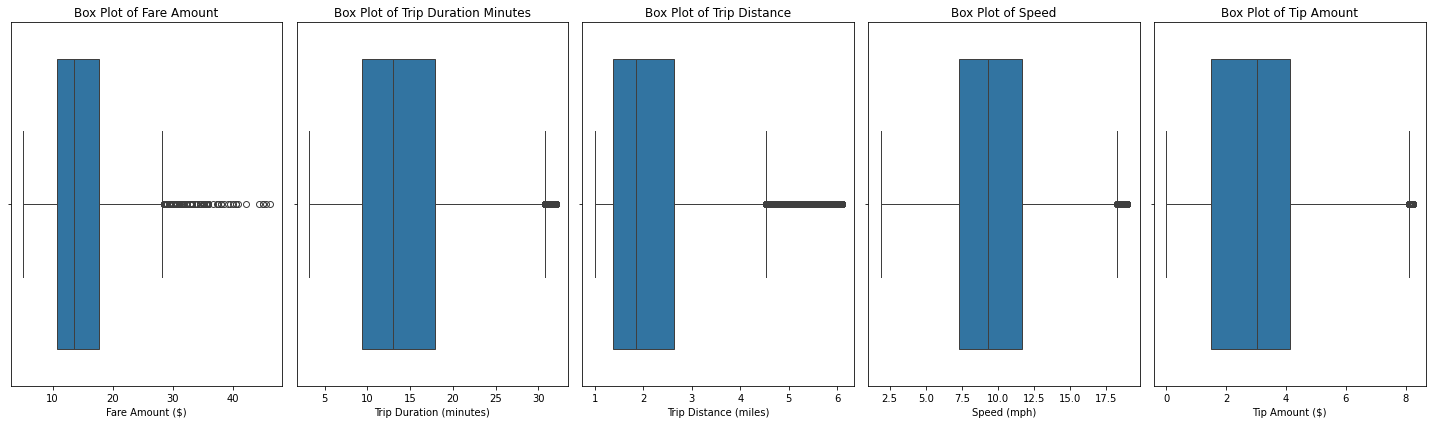

In [12]:
# Set the size of the entire figure
plt.figure(figsize=(20, 6))

# Create a subplot for the fare amount
plt.subplot(1, 5, 1)  # 1 row, 5 columns, 1st subplot
sns.boxplot(x=df_cleaned['fare_amount'])
plt.title('Box Plot of Fare Amount')
plt.xlabel('Fare Amount ($)')

# Create a subplot for the trip duration
plt.subplot(1, 5, 2)  # 1 row, 5 columns, 2nd subplot
sns.boxplot(x=df_cleaned['trip_duration'])
plt.title('Box Plot of Trip Duration Minutes')
plt.xlabel('Trip Duration (minutes)')

# Create a subplot for the trip distance
plt.subplot(1, 5, 3)  # 1 row, 5 columns, 3rd subplot
sns.boxplot(x=df_cleaned['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.xlabel('Trip Distance (miles)')

# Create a subplot for the speed
plt.subplot(1, 5, 4)  # 1 row, 5 columns, 4th subplot
sns.boxplot(x=df_cleaned['speed_mph'])
plt.title('Box Plot of Speed')
plt.xlabel('Speed (mph)')

# Create a subplot for the tip amount
plt.subplot(1, 5, 5)  # 1 row, 5 columns, 5th subplot
sns.boxplot(x=df_cleaned['tip_amount'])
plt.title('Box Plot of Tip Amount')
plt.xlabel('Tip Amount ($)')

# Display the plot
plt.tight_layout()

## 2. Transforming Numeric Features 

As we saw numeric features we want to use are righ skewed are not normally distributed thus log transofrmation is a good step to ensure predictive power of the model.

In [13]:
# Apply log transformation to skewed numerical features
df_cleaned['trip_distance'] = np.log1p(df_cleaned['trip_distance'])
df_cleaned['trip_duration'] = np.log1p(df_cleaned['trip_duration'])
df_cleaned['tip_amount'] = np.log1p(df_cleaned['tip_amount'])

In [17]:
df_cleaned.head()

,trip_distance,trip_duration,speed_mph,tip_amount,pickup_time_of_day,pickup_day_type,pickup_season,is_holiday,PUcategory,DOcategory,fare_amount
19861556,1.564441,2.858384,13.801217,2.135349,afternoon,weekday,autumn,0,Airport,Suburbs,19.1
20389403,1.490654,2.649715,15.695817,1.788421,afternoon,weekday,autumn,0,Airport,Suburbs,18.4
22548453,1.078410,2.282382,13.227273,0.000000,afternoon,weekend,autumn,0,Airport,Airport,12.1
22368807,1.867176,3.152736,14.651786,2.099244,afternoon,weekday,autumn,0,Airport,Suburbs,26.8
20320646,1.371181,2.491827,15.915789,1.876407,afternoon,weekday,autumn,0,Airport,Suburbs,15.6


In [18]:
df_cleaned.columns

Index(['trip_distance', 'trip_duration', 'speed_mph', 'tip_amount',
       'pickup_time_of_day', 'pickup_day_type', 'pickup_season', 'is_holiday',
       'PUcategory', 'DOcategory', 'fare_amount'],
      dtype='object')

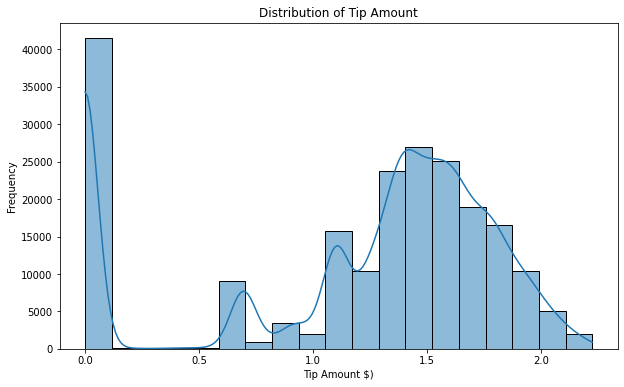

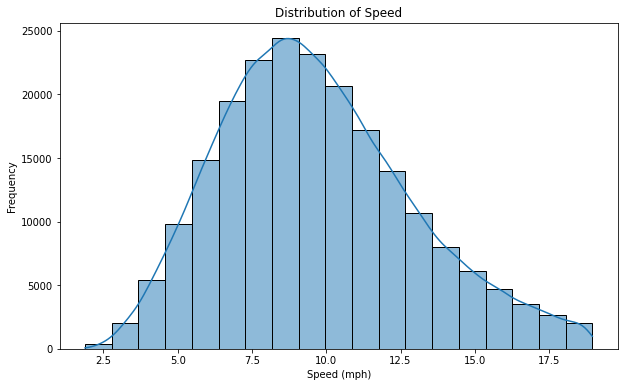

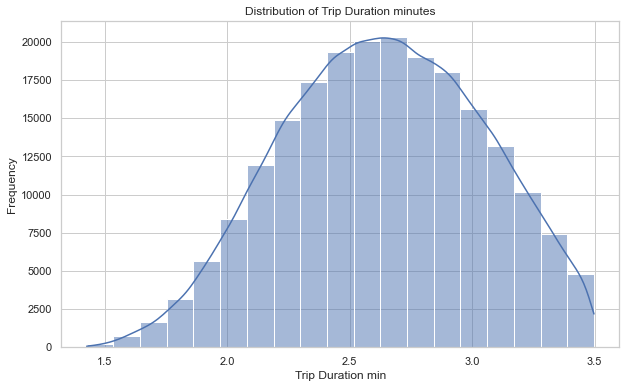

In [17]:
num_bins = int(np.ceil(1 + np.log2(len(df_cleaned['tip_amount']))))
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['tip_amount'], bins=num_bins, kde=True)
plt.title('Distribution of Tip Amount')
plt.xlabel('Tip Amount $)')
plt.ylabel('Frequency')
plt.show()

num_bins = int(np.ceil(1 + np.log2(len(df_cleaned['speed_mph']))))
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['speed_mph'], bins=num_bins, kde=True)
plt.title('Distribution of Speed')
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')
plt.show()

num_bins = int(np.ceil(1 + np.log2(len(df_cleaned['trip_duration']))))

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Histogram for Fare Amount
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['trip_duration'], bins=num_bins, kde=True)
plt.title('Distribution of Trip Duration minutes')
plt.xlabel('Trip Duration min')
plt.ylabel('Frequency')
plt.show()

## 3. Encoding Categorical Features

for better moedl predictions memory usage we will encode categorical features that are relavant for our modeling.

In [13]:

# Define categorical features
categorical_features = ['pickup_time_of_day', 'pickup_day_type', 'pickup_season', 'is_holiday', 'PUcategory', 'DOcategory']

In [14]:

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)


In [15]:

# Fit and transform the data
encoded_features = encoder.fit_transform(df_cleaned[categorical_features])


In [16]:

# Convert encoded features to DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(categorical_features))



In [17]:

# Drop original categorical columns and concatenate encoded columns
df_encoded = df_cleaned.drop(columns=categorical_features).reset_index(drop=True)
df_encoded = pd.concat([df_encoded, encoded_df], axis=1)

df_encoded.head()

,trip_distance,trip_duration,speed_mph,tip_amount,fare_amount,pickup_time_of_day_evening,pickup_time_of_day_morning,pickup_time_of_day_night,pickup_day_type_weekend,pickup_season_spring,pickup_season_summer,pickup_season_winter,is_holiday_1,PUcategory_City Center,PUcategory_Other,PUcategory_Suburbs,DOcategory_City Center,DOcategory_Other,DOcategory_Suburbs
0,1.564441,2.858384,13.801217,2.135349,19.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.490654,2.649715,15.695817,1.788421,18.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.078410,2.282382,13.227273,0.000000,12.1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.867176,3.152736,14.651786,2.099244,26.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.371181,2.491827,15.915789,1.876407,15.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 5. Scaling Data

In [18]:
# Define numerical features for scaling
numerical_features = ['trip_distance', 'trip_duration', 'speed_mph', 'tip_amount']


In [19]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
scaled_features = scaler.fit_transform(df_encoded[numerical_features])


In [20]:

# Convert scaled features to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=numerical_features)


In [21]:

# Drop original numerical columns and concatenate scaled columns
df_scaled = df_encoded.drop(columns=numerical_features).reset_index(drop=True)
df_scaled = pd.concat([df_scaled, scaled_df], axis=1)

df_scaled.head()


,fare_amount,pickup_time_of_day_evening,pickup_time_of_day_morning,pickup_time_of_day_night,pickup_day_type_weekend,pickup_season_spring,pickup_season_summer,pickup_season_winter,is_holiday_1,PUcategory_City Center,PUcategory_Other,PUcategory_Suburbs,DOcategory_City Center,DOcategory_Other,DOcategory_Suburbs,trip_distance,trip_duration,speed_mph,tip_amount
0,19.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.552775,0.546529,1.274543,1.457337
1,18.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.303941,0.033668,1.859308,0.927532
2,12.1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.086298,-0.869149,1.097397,-1.803617
3,26.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.573709,1.269977,1.537070,1.402200
4,15.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.901032,-0.354383,1.927202,1.061899


In [22]:
# Check for null values
null_values = df_scaled.isnull().sum()
print("Null values in each column:\n", null_values)

# Check if there are any rows with null values
rows_with_nulls = df_scaled[df_scaled.isnull().any(axis=1)]
print("Number of rows with null values:", len(rows_with_nulls))


Null values in each column:
 fare_amount                   0
pickup_time_of_day_evening    0
pickup_time_of_day_morning    0
pickup_time_of_day_night      0
pickup_day_type_weekend       0
pickup_season_spring          0
pickup_season_summer          0
pickup_season_winter          0
is_holiday_1                  0
PUcategory_City Center        0
PUcategory_Other              0
PUcategory_Suburbs            0
DOcategory_City Center        0
DOcategory_Other              0
DOcategory_Suburbs            0
trip_distance                 0
trip_duration                 0
speed_mph                     0
tip_amount                    0
dtype: int64
Number of rows with null values: 0


In [23]:
# Verify the types of values in each column
value_types = df_scaled.dtypes
print("Data types of each column:\n", value_types)


Data types of each column:
 fare_amount                   float64
pickup_time_of_day_evening    float64
pickup_time_of_day_morning    float64
pickup_time_of_day_night      float64
pickup_day_type_weekend       float64
pickup_season_spring          float64
pickup_season_summer          float64
pickup_season_winter          float64
is_holiday_1                  float64
PUcategory_City Center        float64
PUcategory_Other              float64
PUcategory_Suburbs            float64
DOcategory_City Center        float64
DOcategory_Other              float64
DOcategory_Suburbs            float64
trip_distance                 float64
trip_duration                 float64
speed_mph                     float64
tip_amount                    float64
dtype: object


In [24]:
# Check the first few rows to ensure all categories were encoded
encoded_features = df_scaled.columns[df_scaled.columns.str.startswith(tuple(categorical_features))]
print("Encoded categorical features:\n", encoded_features)

# Display the first few rows of the dataset to visually inspect the encoded features
df_scaled.head()


Encoded categorical features:
 Index(['pickup_time_of_day_evening', 'pickup_time_of_day_morning',
       'pickup_time_of_day_night', 'pickup_day_type_weekend',
       'pickup_season_spring', 'pickup_season_summer', 'pickup_season_winter',
       'is_holiday_1', 'PUcategory_City Center', 'PUcategory_Other',
       'PUcategory_Suburbs', 'DOcategory_City Center', 'DOcategory_Other',
       'DOcategory_Suburbs'],
      dtype='object')


,fare_amount,pickup_time_of_day_evening,pickup_time_of_day_morning,pickup_time_of_day_night,pickup_day_type_weekend,pickup_season_spring,pickup_season_summer,pickup_season_winter,is_holiday_1,PUcategory_City Center,PUcategory_Other,PUcategory_Suburbs,DOcategory_City Center,DOcategory_Other,DOcategory_Suburbs,trip_distance,trip_duration,speed_mph,tip_amount
0,19.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.552775,0.546529,1.274543,1.457337
1,18.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.303941,0.033668,1.859308,0.927532
2,12.1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.086298,-0.869149,1.097397,-1.803617
3,26.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.573709,1.269977,1.537070,1.402200
4,15.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.901032,-0.354383,1.927202,1.061899


In [25]:
df_scaled.columns

Index(['fare_amount', 'pickup_time_of_day_evening',
       'pickup_time_of_day_morning', 'pickup_time_of_day_night',
       'pickup_day_type_weekend', 'pickup_season_spring',
       'pickup_season_summer', 'pickup_season_winter', 'is_holiday_1',
       'PUcategory_City Center', 'PUcategory_Other', 'PUcategory_Suburbs',
       'DOcategory_City Center', 'DOcategory_Other', 'DOcategory_Suburbs',
       'trip_distance', 'trip_duration', 'speed_mph', 'tip_amount'],
      dtype='object')

In [53]:
df_scaled.to_parquet('modeling_dataset.parquet')

# Modeling

## 6. Splitting Testing and Training

In [29]:
# Define target and features
X = df_scaled.drop(columns=['fare_amount'])
y = df_scaled['fare_amount']

In [30]:

# First split: Train + Validation and Test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


## 7. Training the models

In [31]:
# Baseline Model: Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_train = linear_model.predict(X_train)
y_pred_val = linear_model.predict(X_val)

print("Linear Regression Performance")
print("Training MAE:", mean_absolute_error(y_train, y_pred_train))
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val))
print("Validation R²:", r2_score(y_val, y_pred_val))


Linear Regression Performance
Training MAE: 0.9653517503368936
Validation MAE: 0.959558476565067
Validation R²: 0.9394005000522753


In [32]:
# Decision Tree with Grid Search for parameter tuning
param_grid_dt = {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
dt_grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_dt, cv=3, n_jobs=-1)
dt_grid_search.fit(X_train, y_train)
best_dt_model = dt_grid_search.best_estimator_
y_pred_val_dt = best_dt_model.predict(X_val)
print("Decision Tree Performance")
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val_dt))
print("Validation R²:", r2_score(y_val, y_pred_val_dt))

Decision Tree Performance
Validation MAE: 0.492544414897988
Validation R²: 0.976438980144165


In [33]:
# Gradient Boosting with early stopping
gb_model = GradientBoostingRegressor(n_estimators=100, validation_fraction=0.1, n_iter_no_change=10)
gb_model.fit(X_train, y_train)
y_pred_val_gb = gb_model.predict(X_val)
print("Gradient Boosting Performance")
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val_gb))
print("Validation R²:", r2_score(y_val, y_pred_val_gb))

Gradient Boosting Performance
Validation MAE: 0.49551348356561264
Validation R²: 0.9777006149079904


In [34]:
# XGBoost with Grid Search for parameter tuning
param_grid_xgb = {'n_estimators': [50, 100], 'max_depth': [3, 6, 10], 'learning_rate': [0.01, 0.1]}
xgb_grid_search = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid_xgb, cv=3, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)
best_xgb_model = xgb_grid_search.best_estimator_
y_pred_val_xgb = best_xgb_model.predict(X_val)
print("XGBoost Performance")
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val_xgb))
print("Validation R²:", r2_score(y_val, y_pred_val_xgb))

XGBoost Performance
Validation MAE: 0.395052953680181
Validation R²: 0.9824132080091474


In [36]:
# Random Forest with Randomized Search for parameter tuning using a smaller sample and fewer folds
param_dist_rf = {'n_estimators': [10, 50], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

# Set n_iter to the number of unique parameter combinations
rf_random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=param_dist_rf, n_iter=8, cv=2, n_jobs=-1, random_state=42)
rf_random_search.fit(X_train_sample, y_train_sample)
best_rf_model = rf_random_search.best_estimator_
final_rf_model = RandomForestRegressor(**best_rf_model.get_params())
final_rf_model.fit(X_train, y_train)
y_pred_val_rf = final_rf_model.predict(X_val)
#Performance metrics
print("Random Forest Performance")
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val_rf))
print("Validation R²:", r2_score(y_val, y_pred_val_rf))

Random Forest Performance
Validation MAE: 0.46103824388917203
Validation R²: 0.9792158120246218


In [42]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']
val_mae = [
    mean_absolute_error(y_val, y_pred_val),
    mean_absolute_error(y_val, y_pred_val_dt),
    mean_absolute_error(y_val, y_pred_val_rf),
    mean_absolute_error(y_val, y_pred_val_gb),
    mean_absolute_error(y_val, y_pred_val_xgb)
    
]
val_r2 = [
    r2_score(y_val, y_pred_val),
    r2_score(y_val, y_pred_val_dt),
    r2_score(y_val, y_pred_val_rf),
    r2_score(y_val, y_pred_val_gb),
    r2_score(y_val, y_pred_val_xgb)
   
]

performance_df = pd.DataFrame({
    'Model': models,
    'Validation MAE': val_mae,
    'Validation R²': val_r2
})

print(performance_df)

               Model  Validation MAE  Validation R²
0  Linear Regression        0.959558       0.939401
1      Decision Tree        0.492544       0.976439
2      Random Forest        0.461038       0.979216
3  Gradient Boosting        0.495513       0.977701
4            XGBoost        0.395053       0.982413


# Model Testing

In [45]:
# Linear Regression
y_pred_test_linear = linear_model.predict(X_test)

# Decision Tree
y_pred_test_dt = best_dt_model.predict(X_test)

# Gradient Boosting
y_pred_test_gb = gb_model.predict(X_test)

# XGBoost
y_pred_test_xgb = best_xgb_model.predict(X_test)

# Random Forest
y_pred_test_rf = final_rf_model.predict(X_test)


In [46]:
print("Test Set Performance:")

# Linear Regression
print("Linear Regression")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_linear))
print("Test R²:", r2_score(y_test, y_pred_test_linear))

# Decision Tree
print("\nDecision Tree")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_dt))
print("Test R²:", r2_score(y_test, y_pred_test_dt))

# Gradient Boosting
print("\nGradient Boosting")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_gb))
print("Test R²:", r2_score(y_test, y_pred_test_gb))

# XGBoost
print("\nXGBoost")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_xgb))
print("Test R²:", r2_score(y_test, y_pred_test_xgb))

# Random Forest
print("\nRandom Forest")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_rf))
print("Test R²:", r2_score(y_test, y_pred_test_rf))


Test Set Performance:
Linear Regression
Test MAE: 0.9646963443501171
Test R²: 0.9377321782393591

Decision Tree
Test MAE: 0.49967909590027343
Test R²: 0.9749291443098009

Gradient Boosting
Test MAE: 0.4993499842587564
Test R²: 0.9769813029142241

XGBoost
Test MAE: 0.39761920091213754
Test R²: 0.9810769640916153

Random Forest
Test MAE: 0.4631682475526342
Test R²: 0.9785779237264908


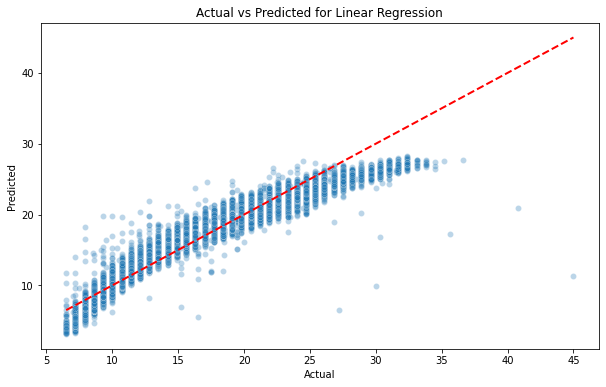

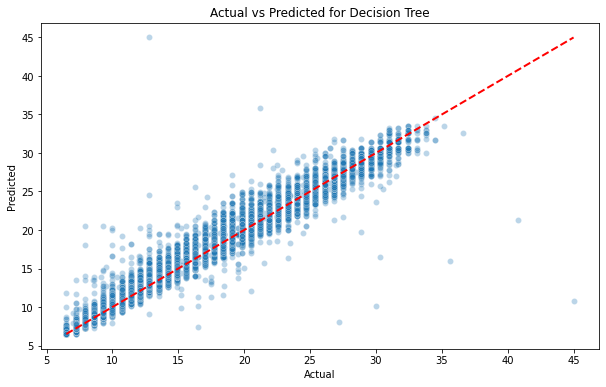

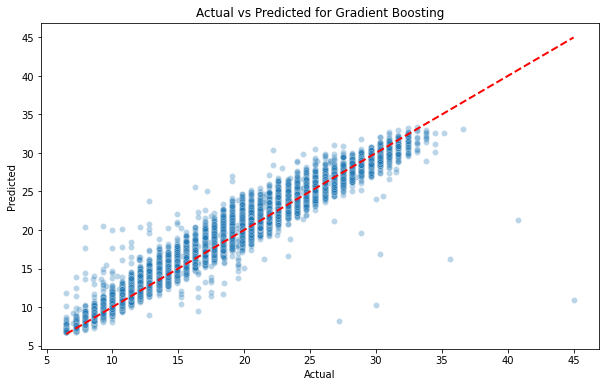

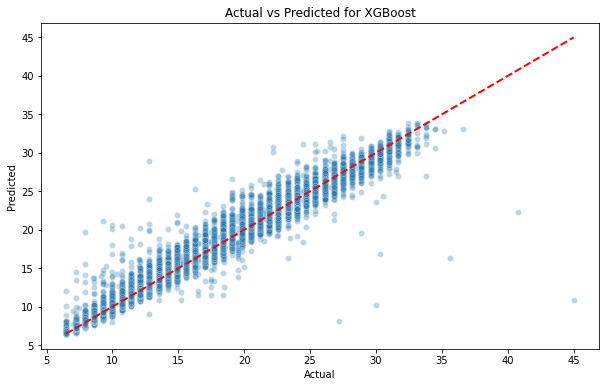

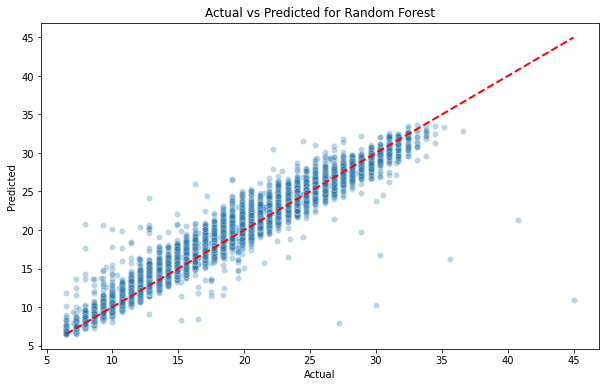

In [48]:
# Linear Regression
plot_actual_vs_predicted(y_test, y_pred_test_linear, 'Linear Regression')

# Decision Tree
plot_actual_vs_predicted(y_test, y_pred_test_dt, 'Decision Tree')

# Gradient Boosting
plot_actual_vs_predicted(y_test, y_pred_test_gb, 'Gradient Boosting')

# XGBoost
plot_actual_vs_predicted(y_test, y_pred_test_xgb, 'XGBoost')

# Random Forest
plot_actual_vs_predicted(y_test, y_pred_test_rf, 'Random Forest')

# Residuals Analysis

In [49]:
# Calculate residuals
residuals_linear = y_test - y_pred_test_linear
residuals_dt = y_test - y_pred_test_dt
residuals_gb = y_test - y_pred_test_gb
residuals_xgb = y_test - y_pred_test_xgb
residuals_rf = y_test - y_pred_test_rf


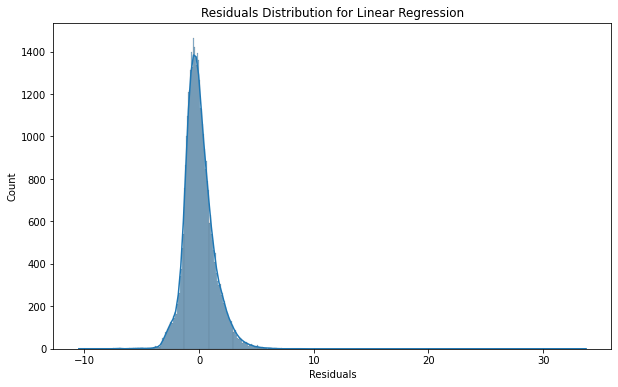

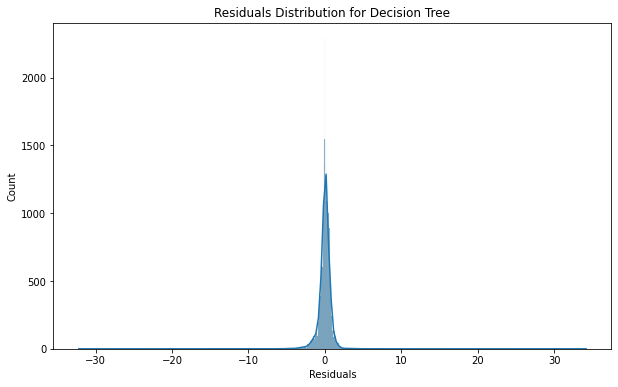

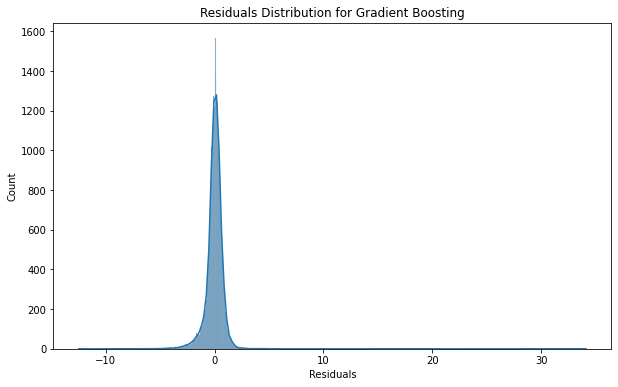

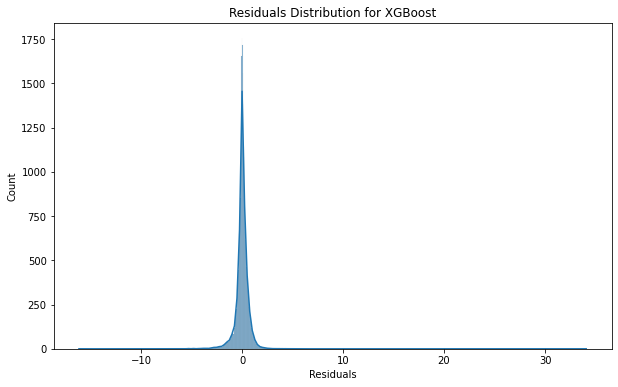

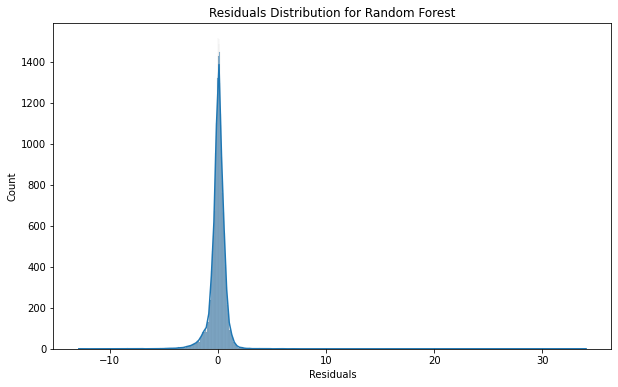

In [51]:


# Plot residuals for each model
plot_residuals(y_test, residuals_linear, 'Linear Regression')
plot_residuals(y_test, residuals_dt, 'Decision Tree')
plot_residuals(y_test, residuals_gb, 'Gradient Boosting')
plot_residuals(y_test, residuals_xgb, 'XGBoost')
plot_residuals(y_test, residuals_rf, 'Random Forest')


In [52]:
# Collect performance metrics for the test set
test_mae = [
    mean_absolute_error(y_test, y_pred_test_linear),
    mean_absolute_error(y_test, y_pred_test_dt),
    mean_absolute_error(y_test, y_pred_test_rf),
    mean_absolute_error(y_test, y_pred_test_gb),
    mean_absolute_error(y_test, y_pred_test_xgb)
]

test_r2 = [
    r2_score(y_test, y_pred_test_linear),
    r2_score(y_test, y_pred_test_dt),
    r2_score(y_test, y_pred_test_rf),
    r2_score(y_test, y_pred_test_gb),
    r2_score(y_test, y_pred_test_xgb)
]

# Create a DataFrame to summarize test performance
test_performance_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Test MAE': test_mae,
    'Test R²': test_r2
})

print(test_performance_df)


               Model  Test MAE   Test R²
0  Linear Regression  0.964696  0.937732
1      Decision Tree  0.499679  0.974929
2      Random Forest  0.463168  0.978578
3  Gradient Boosting  0.499350  0.976981
4            XGBoost  0.397619  0.981077


# Ensemble Model 

An ensemble model combines multiple machine learning models to improve predictive performance. The idea is to leverage the strengths of different models and mitigate their individual weaknesses. In your case, the ensemble model is built using VotingRegressor, which combines predictions from several regressors, including LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor, and XGBRegressor.



In [59]:
from sklearn.ensemble import VotingRegressor

# Initialize the models
linear_model = LinearRegression()
dt_model = DecisionTreeRegressor(max_depth=best_dt_model.get_params()['max_depth'])
rf_model = RandomForestRegressor(**best_rf_model.get_params())
gb_model = GradientBoostingRegressor(n_estimators=100, validation_fraction=0.1, n_iter_no_change=10)
xgb_model = best_xgb_model



In [60]:
# Create an ensemble model
ensemble_model = VotingRegressor(
    estimators=[
        ('lr', linear_model),
        ('dt', dt_model),
        ('rf', rf_model),
        ('gb', gb_model),
        ('xgb', xgb_model)
    ]
)

In [61]:
# Fit the ensemble model
ensemble_model.fit(X_train, y_train)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('dt', DecisionTreeRegressor(max_depth=10)),
                            ('rf',
                             RandomForestRegressor(max_depth=10,
                                                   min_samples_split=5,
                                                   n_estimators=50,
                                                   random_state=42)),
                            ('gb',
                             GradientBoostingRegressor(n_iter_no_change=10)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=...
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                

In [62]:
# Evaluate the ensemble model
y_pred_val_ensemble = ensemble_model.predict(X_val)
print("Ensemble Model Performance")
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val_ensemble))
print("Validation R²:", r2_score(y_val, y_pred_val_ensemble))


Ensemble Model Performance
Validation MAE: 0.4821736579432613
Validation R²: 0.9787618220362403


In [75]:
# Ensemble model testing
y_pred_test_ensemble = ensemble_model.predict(X_test)

In [76]:
# Ensemble Model Testing
print("\nRandom Forest")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_rf))
print("Test R²:", r2_score(y_test, y_pred_test_rf))



Random Forest
Test MAE: 0.4631682475526342
Test R²: 0.9785779237264908


We can see that model performs well on test set alike from its scores.

# Comparing Ensemble Model To Other models

In [79]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost','Ensemble']
val_mae = [
    mean_absolute_error(y_val, y_pred_val),
    mean_absolute_error(y_val, y_pred_val_dt),
    mean_absolute_error(y_val, y_pred_val_rf),
    mean_absolute_error(y_val, y_pred_val_gb),
    mean_absolute_error(y_val, y_pred_val_xgb),
    mean_absolute_error(y_val, y_pred_val_ensemble)
    
    
]
val_r2 = [
    r2_score(y_val, y_pred_val),
    r2_score(y_val, y_pred_val_dt),
    r2_score(y_val, y_pred_val_rf),
    r2_score(y_val, y_pred_val_gb),
    r2_score(y_val, y_pred_val_xgb),
     r2_score(y_val, y_pred_val_ensemble)
   
]

performance_df = pd.DataFrame({
    'Model': models,
    'Validation MAE': val_mae,
    'Validation R²': val_r2
})

print(performance_df)

               Model  Validation MAE  Validation R²
0  Linear Regression        0.959558       0.939401
1      Decision Tree        0.492544       0.976439
2      Random Forest        0.461038       0.979216
3  Gradient Boosting        0.495513       0.977701
4            XGBoost        0.395053       0.982413
5           Ensemble        0.482174       0.978762


### Interpretation

- **XGBoost** stands out as the best-performing individual model with the lowest validation MAE (0.395053) and the highest validation R² (0.982413), indicating that it provides the most accurate and reliable predictions.
- **Random Forest** and **Gradient Boosting** also perform very well, with slightly higher MAE and lower R² compared to XGBoost but still providing strong performance.
- The **Ensemble model**, which combines the predictions from multiple models, performs slightly worse than XGBoost in terms of MAE but has a high R² (0.978762). This suggests that while it may not be as accurate as XGBoost alone, it still provides a robust and reliable prediction by leveraging multiple models.
- **Linear Regression** performs the worst among the models, indicating that it may not be suitable for this particular problem where the relationships between features and target variable are likely nonlinear and complex.

### Conclusion

- **XGBoost** is likely your best model for deployment based on its superior performance metrics.
- The **Ensemble model** is a close contender, offering robustness by combining various models, which can be beneficial if you aim for more generalized predictions.
- Other models like **Random Forest** and **Gradient Boosting** also perform well and can be considered as alternative options if needed.

By analyzing these metrics, you can make an informed decision on which model to use for your taxi fare prediction application, balancing accuracy, robustness, and interpretability.

## Feature Importance For Best Performing Model

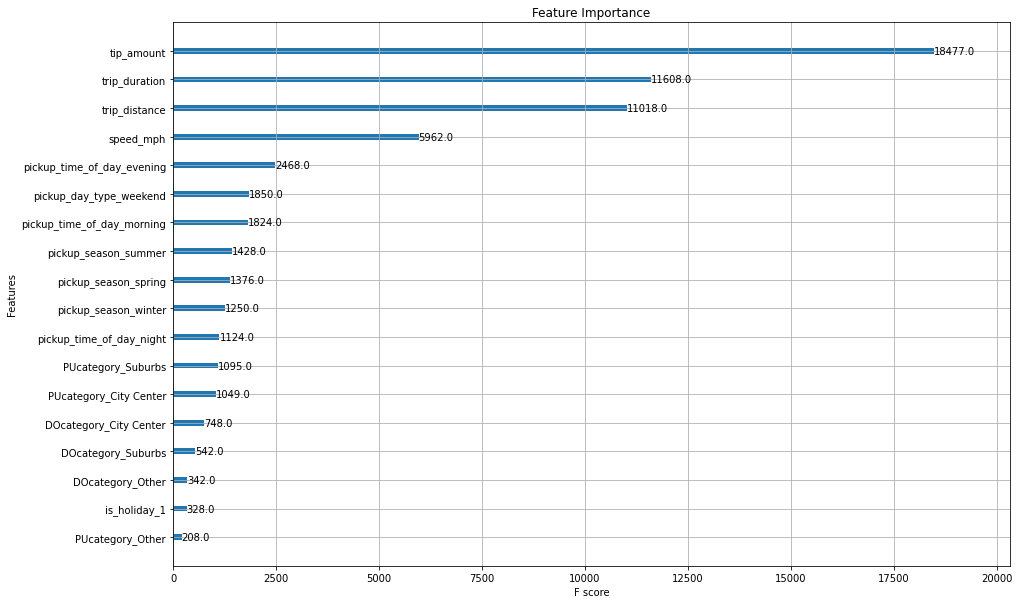

In [74]:
# Assuming `best_xgb_model` is your trained XGBoost model
fig, ax = plt.subplots(figsize=(15, 10))  # Set the figure size
xgb.plot_importance(best_xgb_model, importance_type='weight', ax=ax)
plt.title('Feature Importance')
plt.show()

We see that for the best performing model tip amount trip duration and distance had the highest weights which is not surprising. It is also interesting to see how weights varied for categorical features as well.

## XGboost Model Croos Validation

In [65]:

# Perform cross-validation for the best XGBoost model
cv_scores = cross_val_score(best_xgb_model, X, y, cv=5, scoring='neg_mean_absolute_error')

print("Cross-Validation MAE Scores:", -cv_scores)
print("Mean Cross-Validation MAE:", -cv_scores.mean())


Cross-Validation MAE Scores: [0.38794758 0.39758518 0.39625821 0.38914303 0.39573576]
Mean Cross-Validation MAE: 0.3933339537623851


### What the Scores Tell Us

- **Consistency**: The individual cross-validation MAE scores are quite close to each other, ranging between approximately 0.3879 and 0.3976. This consistency indicates that the model performs similarly across different subsets of the data, suggesting that it is not overly sensitive to the specific data it was trained on.
- **Generalizability**: The mean cross-validation MAE of approximately 0.3933 is quite low, indicating that on average, the model's predictions are very close to the actual values. This suggests that the model generalizes well to new, unseen data.
- **Reliability**: The close range of the MAE scores and the low mean value imply that the model is reliable and robust. There are no significant deviations in performance across the folds, which means the model is likely to perform well in practical, real-world applications.

### Practical Implications

- **Model Selection**: These cross-validation scores, especially the low mean MAE, reinforce the decision to use this model (XGBoost in this case) as a top candidate for deployment.
- **Model Confidence**: The consistency and low error rates provide confidence that the model will not only perform well on the validation and test sets but also on any new data it encounters in production.
- **Further Fine-Tuning**: While the scores are already good, you could explore further fine-tuning or ensembling if you aim to squeeze out even better performance. However, the current performance indicates that major improvements might be marginal.

### Conclusion

The cross-validation scores suggest that the XGBoost model is performing very well, with low and consistent MAE across different folds of the dataset. This indicates that the model is robust, generalizes well to new data, and is a reliable choice for your taxi fare prediction task. This reinforces the earlier conclusion that XGBoost is one of the best-performing models and is suitable for deployment.

# Summary 

### End Summary

#### Objective
The primary goal of this study was to develop a predictive model for taxi fares using the NYC yellow taxi trip dataset from 2023. This model aims to identify key influencing factors for taxi fares to develop a structured fare system for Tbilisi, Georgia.

#### Key Findings
Through exploratory data analysis, it was identified that:
- Fare amounts are highly right-skewed and strongly correlated with trip distance and duration.
- Factors such as time of day, day type, season, and holidays significantly impact fare amounts.
- Proper handling of outliers and data transformations were crucial for model accuracy.

#### Data Preprocessing
- **Outlier Removal**: Utilized the IQR method.
- **Log Transformation**: Applied to skewed numerical features.
- **One-Hot Encoding**: Categorical features were encoded.
- **Standard Scaling**: Applied to numerical features to normalize the data.

#### Model Development and Performance
Several models were developed and evaluated:
- **Linear Regression**
- **Decision Tree**
- **Random Forest**
- **Gradient Boosting**
- **XGBoost**
- **Ensemble Model** (combining the above models)

**Model Performance on Validation Set:**
- **XGBoost**: MAE = 0.395, R² = 0.982 (best-performing model)
- **Random Forest**: MAE = 0.461, R² = 0.979
- **Gradient Boosting**: MAE = 0.496, R² = 0.978
- **Ensemble Model**: MAE = 0.482, R² = 0.979
- **Decision Tree**: MAE = 0.493, R² = 0.976
- **Linear Regression**: MAE = 0.959, R² = 0.939

**Model Performance on Test Set:**
- **XGBoost**: MAE = 0.398, R² = 0.981 (best-performing model)
- **Random Forest**: MAE = 0.463, R² = 0.979
- **Gradient Boosting**: MAE = 0.499, R² = 0.977
- **Ensemble Model**: MAE = 0.482, R² = 0.979
- **Decision Tree**: MAE = 0.500, R² = 0.975
- **Linear Regression**: MAE = 0.965, R² = 0.938

#### Residual Analysis
Residuals for each model were analyzed, showing that:
- The models generally had a good fit, with XGBoost showing the best performance in terms of residual distribution.

#### Cross-Validation for XGBoost
Cross-validation for XGBoost indicated:
- Consistent and low mean absolute errors across folds, confirming the model's reliability and robustness.

#### Conclusion
- **Best Model**: XGBoost, due to its superior performance metrics.
- **Close Contenders**: Ensemble model and Random Forest, both providing robust performance.
- **Recommendation**: Deploy the XGBoost model for taxi fare prediction, with the Ensemble model as a backup for more generalized predictions.

#### Practical Implications
The findings and models developed in this study provide a reliable and accurate method for predicting taxi fares. This can be directly applied to implement a structured fare system in Tbilisi, ensuring fair pricing based on trip characteristics.
In conclusion, the research successfully identified the key factors influencing taxi fares and developed a highly accurate predictive model. The XGBoost model, with its superior performance, is recommended for deployment to create a structured and fair taxi fare system in Tbilisi, enhancing transparency and fairness in fare calculations.

# Saving The XGboost Model 

In [82]:
import joblib
# Save the best XGBoost model
joblib.dump(best_xgb_model, 'xgboost_model_final.pkl')

# Save the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('outlier_removal', FunctionTransformer(remove_outliers)),
    ('log_transform', FunctionTransformer(np.log1p, validate=False)),
    ('onehot_encode', OneHotEncoder(drop='first', sparse=False)),
    ('scaler', StandardScaler())
])
joblib.dump(preprocessing_pipeline, 'preprocessing_pipeline_fianl.pkl')


['preprocessing_pipeline_fianl.pkl']